# PS reconstruction, Gaussian beam

In [1]:
import torch
from copy import deepcopy

import lightning as L

from gpsr.diagnostics import ImageDiagnostic
from gpsr.datasets import SixDReconstructionDataset
from gpsr.modeling import GPSR6DLattice, GPSR
from gpsr.train import LitGPSR
from gpsr.beams import NNParticleBeamGenerator

## Import data

/tmp/ipykernel_1735900/2854734203.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obs_dataset = torch.load("example_data/example_datasets/reconstruction_6D.dset")
/globa

torch.Size([2, 2, 5, 3]) torch.Size([2, 5, 200, 200]) torch.Size([2, 5, 200, 200])


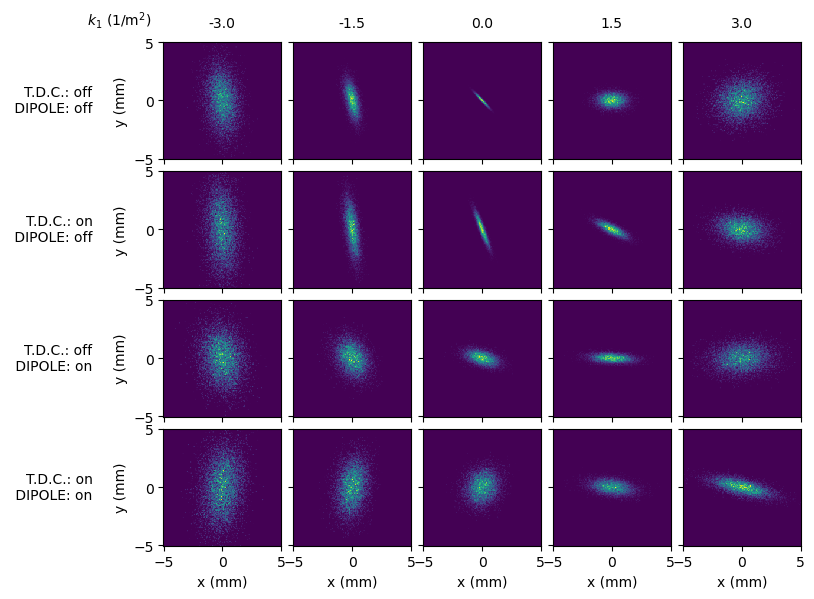

In [2]:
obs_dataset = torch.load("example_data/example_datasets/reconstruction_6D.dset")

print(obs_dataset.parameters.shape, obs_dataset.observations[0].shape, obs_dataset
      .observations[1].shape)

obs_dataset.plot_data(publication_size=True);

Cheetah based version

In [3]:
p0c = 43.36e6 # reference momentum in eV/c

bins = torch.linspace(-5, 5, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

l_quad=0.11
l_tdc=0.01
f_tdc=1.3e9
phi_tdc=0.0
l_bend=0.3018
theta_on=- 20.0 * 3.14 / 180.0
l1=0.790702
l2=0.631698
l3=0.889

gpsr_lattice = GPSR6DLattice(
    l_quad,
    l_tdc,
    f_tdc,
    phi_tdc,
    l_bend,
    theta_on,
    l1,
    l2,
    l3,
    deepcopy(screen),
    deepcopy(screen),
)



## Training using pytorch lightning

In [4]:
gpsr_model = GPSR(NNParticleBeamGenerator(10000, p0c), gpsr_lattice)
train_loader = torch.utils.data.DataLoader(obs_dataset, batch_size=20)

litgpsr = LitGPSR(gpsr_model)
logger = L.pytorch.loggers.TensorBoardLogger('.', )
trainer = L.Trainer(limit_train_batches=100,max_epochs=500, logger=logger)
trainer.fit(model=litgpsr, train_dataloaders=train_loader)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type | Params | Mode 
--------------------------------------------
0 | gpsr_model | GPSR | 1.1 K  | train
--------------------------------------------
1.1 K     Trainable param

Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s, v_num=5]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s, v_num=5]


In [5]:
reconstructed_beam = litgpsr.gpsr_model.beam_generator()

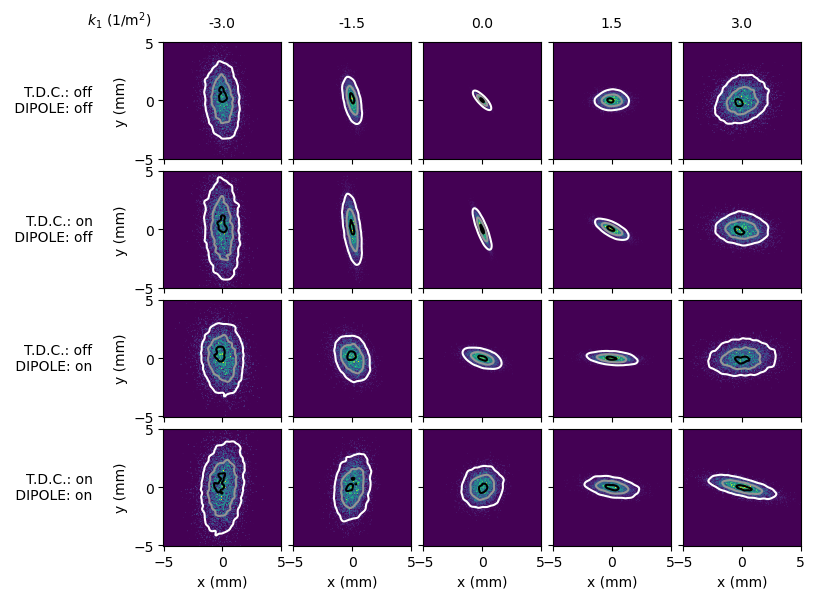

In [6]:
train_params = obs_dataset.parameters
pred = tuple([ele.detach() for ele in gpsr_model(train_params)])
pred_dataset = SixDReconstructionDataset(train_params, pred, (bins, bins))
obs_dataset.plot_data(
    publication_size=True,
    overlay_data=pred_dataset,
    overlay_kwargs={"cmap":"Greys","levels":[0.1,0.5,0.9]}
);


(<Figure size 1200x1200 with 36 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='$p_x$ (mrad)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='$y$ (mm)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='$p_y$ (mrad)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='$tau$ (mm)'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: xlabel='$x$ (mm)', ylabel='$p$ (mrad)'>,
         <Axes: xlabel='$p_x$ (mrad)'>, <Axes: xlabel='$y$ (mm)'>,
         <Axes: xlabel='$p_y$ (mrad)'>, <Axes: xlabel='$tau$ (mm)'>,
         <Axes: xlabel='$p$ (mrad)'>]], dtype=object))

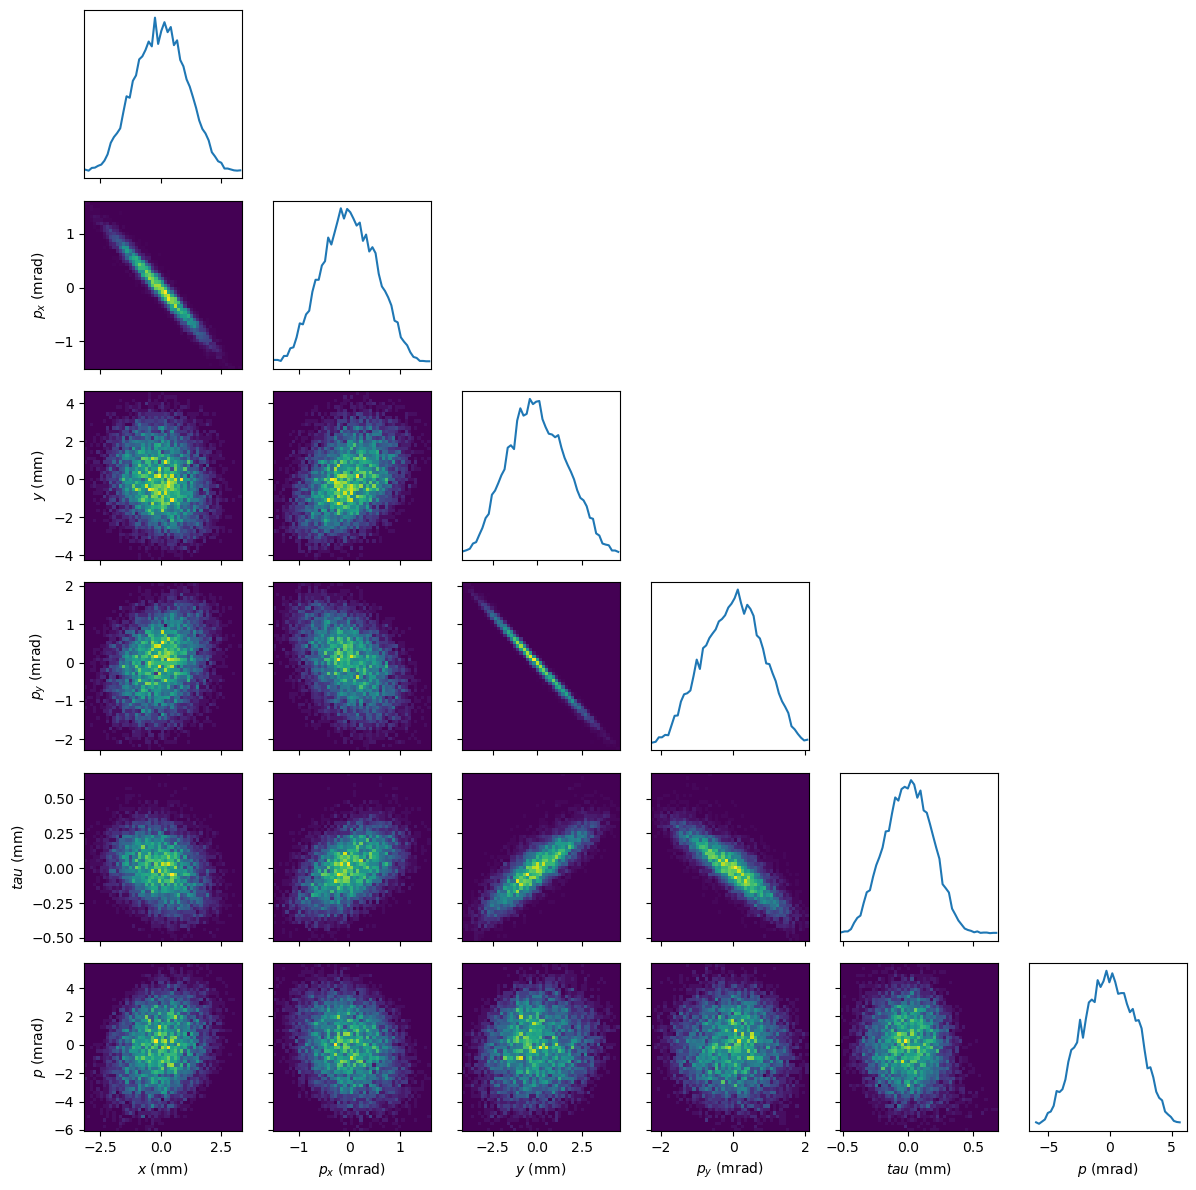

In [7]:
reconstructed_beam.plot_distribution()